# Haar wavelet compression demo (1-level)

Steps:
1) Save a grayscale image to text and binary.
2) Manual 1-level Haar transform.
3) Quantize high-frequency bands (LH, HL, HH) with Q=4.
4) RLE-encode LH, HL, HH (value, count) and save results in order **LL, LH, HL, HH**.
5) Compare sizes with original pixel-by-pixel size.

In [1]:
IMG_PATH = "/mnt/data/periodic_noise.JPG"
print("Using image:", IMG_PATH)


Using image: /mnt/data/periodic_noise.JPG


## Imports & helpers

In [2]:

import os, json
import numpy as np
import cv2
import matplotlib.pyplot as plt

def imread_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    return img

def save_text_binary(img, txt_path, bin_path):
    # text
    np.savetxt(txt_path, img, fmt="%d")
    # binary (raw bytes)
    img.astype(np.uint8).tofile(bin_path)

def haar_1d_pairwise(a, b):
    # average and difference (orthonormal scaled by 1/2)
    # L = (a + b)/2, H = (a - b)/2
    L = (a + b) / 2.0
    H = (a - b) / 2.0
    return L, H

def haar2d_level1(img):
    # ensure even dimensions
    h, w = img.shape
    if h % 2 == 1:
        img = img[:-1,:]
        h -= 1
    if w % 2 == 1:
        img = img[:,:-1]
        w -= 1

    # Row transform
    a = img[:, 0::2].astype(np.float64)
    b = img[:, 1::2].astype(np.float64)
    Lr, Hr = haar_1d_pairwise(a, b)

    # Column transform on Lr and Hr
    aL = Lr[0::2, :]
    bL = Lr[1::2, :]
    LL, HL = haar_1d_pairwise(aL, bL)  # HL: low horizontally, high vertically

    aH = Hr[0::2, :]
    bH = Hr[1::2, :]
    LH, HH = haar_1d_pairwise(aH, bH)  # LH: high horizontally, low vertically

    return LL, LH, HL, HH

def quantize(arr, Q):
    return np.round(arr / Q).astype(np.int16)

def rle_encode(arr):
    # encode a flat array into pairs (value, count)
    flat = arr.flatten()
    values = []
    counts = []
    if flat.size == 0:
        return []
    prev = flat[0]
    cnt = 1
    for v in flat[1:]:
        if v == prev:
            cnt += 1
        else:
            values.append(int(prev))
            counts.append(int(cnt))
            prev = v
            cnt = 1
    values.append(int(prev))
    counts.append(int(cnt))
    return list(zip(values, counts))

def save_pack_text(LL, LHq, HLq, HHq, out_txt):
    with open(out_txt, "w", encoding="utf-8") as f:
        h, w = LL.shape
        f.write(f"shape {h} {w}\n")
        f.write("LL\n")
        np.savetxt(f, LL, fmt="%.6f")
        for name, comp in [("LH", LHq), ("HL", HLq), ("HH", HHq)]:
            f.write(f"{name}_RLE\n")
            pairs = rle_encode(comp)
            for val, cnt in pairs:
                f.write(f"{val} {cnt}\n")

def save_pack_binary(LL, LHq, HLq, HHq, out_bin, Q=4):
    # Simple binary format:
    # magic(4 bytes) 'HAAR' + int32 h + int32 w + int16 Q
    # LL float32 matrix (h/2 x w/2)
    # For each of LH, HL, HH: int32 num_pairs, then sequence of (int16 value, int32 count)
    import struct
    h, w = LL.shape
    with open(out_bin, "wb") as f:
        f.write(b'HAAR')
        f.write(struct.pack('<ii', h, w))
        f.write(struct.pack('<h', Q))

        # LL as float32
        f.write(LL.astype(np.float32).tobytes(order='C'))

        for comp in [LHq, HLq, HHq]:
            pairs = rle_encode(comp)
            f.write(struct.pack('<i', len(pairs)))
            for val, cnt in pairs:
                f.write(struct.pack('<hi', int(val), int(cnt)))

def plot_subbands(LL, LH, HL, HH, title="Haar subbands"):
    plt.figure(figsize=(10,4))
    plt.suptitle(title)
    plt.subplot(1,4,1); plt.imshow(LL, cmap='gray'); plt.title('LL'); plt.axis('off')
    plt.subplot(1,4,2); plt.imshow(LH, cmap='gray'); plt.title('LH'); plt.axis('off')
    plt.subplot(1,4,3); plt.imshow(HL, cmap='gray'); plt.title('HL'); plt.axis('off')
    plt.subplot(1,4,4); plt.imshow(HH, cmap='gray'); plt.title('HH'); plt.axis('off')
    plt.tight_layout()


## Run pipeline

Input shape: (594, 787) dtype: uint8


Sizes (bytes): {'orig_pixel_bytes': 467478, 'orig_text_file': 1595479, 'orig_binary_file': 467478, 'haar_text_pack': 2778468, 'haar_binary_pack': 2475338}


{'orig_pixel_bytes': 467478,
 'orig_text_file': 1595479,
 'orig_binary_file': 467478,
 'haar_text_pack': 2778468,
 'haar_binary_pack': 2475338}

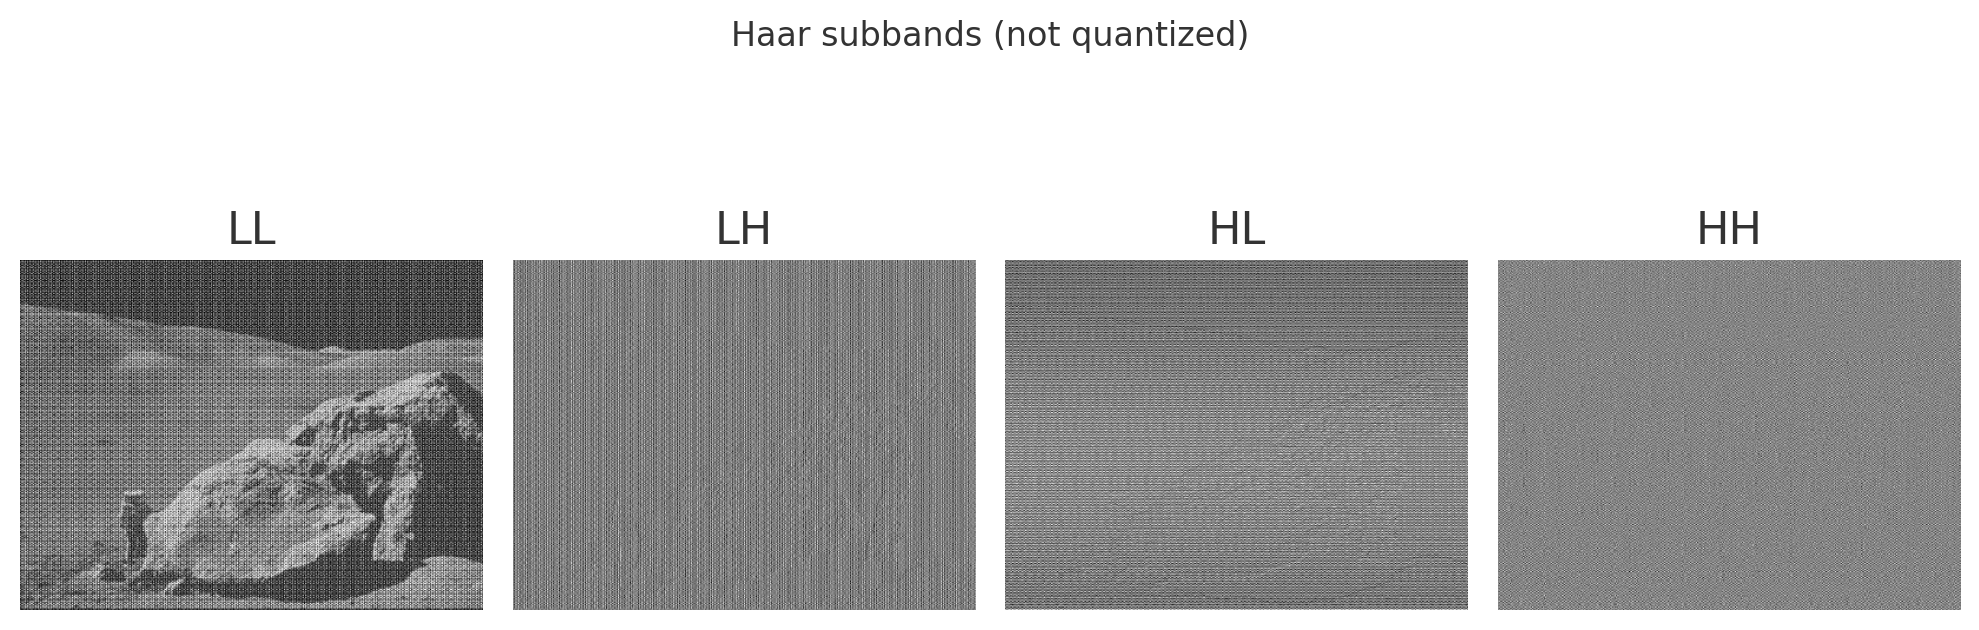

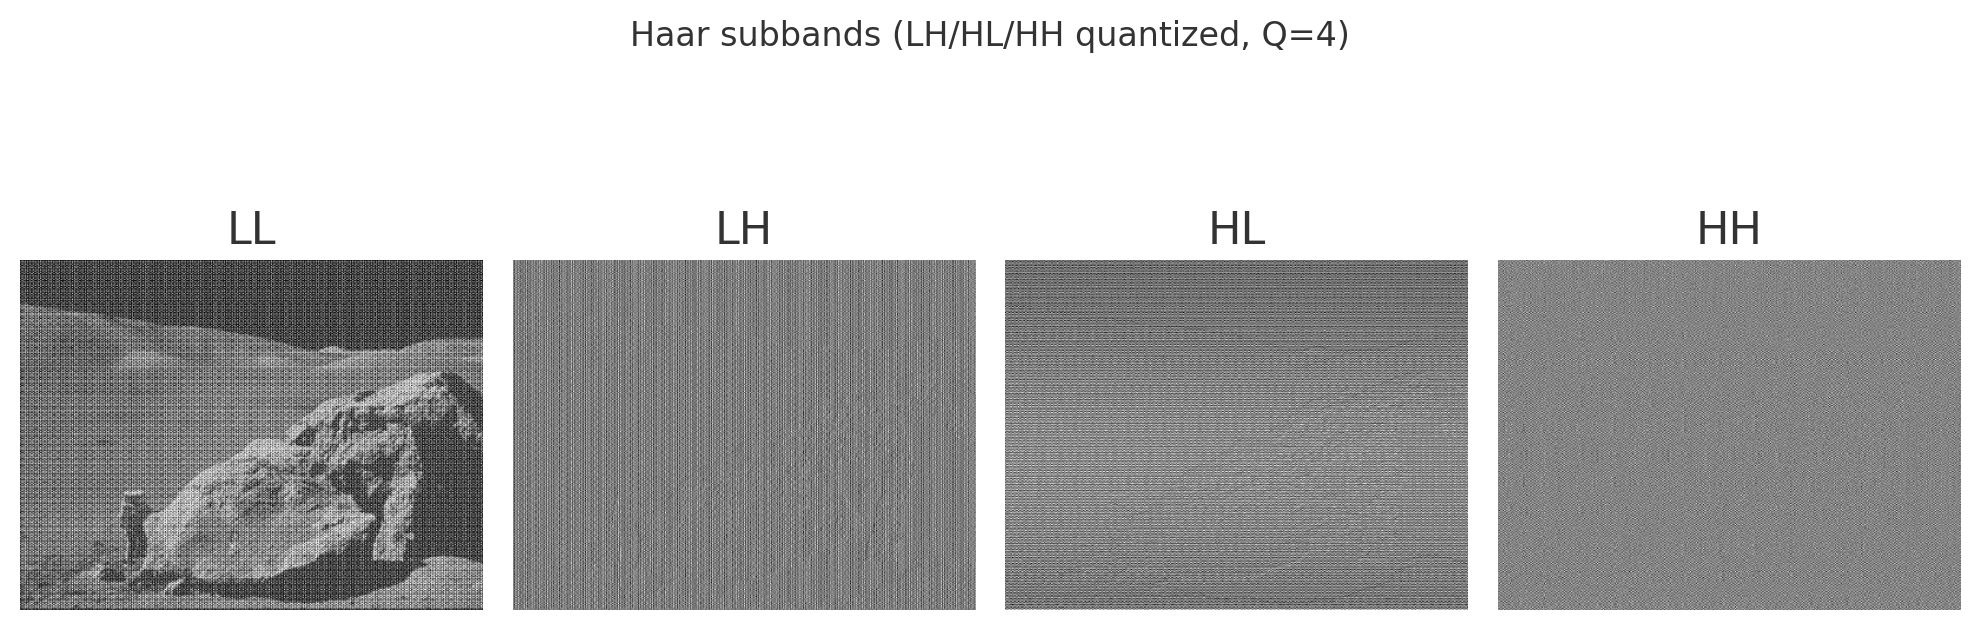

In [3]:

# 1) Read grayscale
img = imread_gray(IMG_PATH)
print("Input shape:", img.shape, "dtype:", img.dtype)

# Save original as text and binary
orig_txt = "/mnt/data/original_image.txt"
orig_bin = "/mnt/data/original_image.bin"
save_text_binary(img, orig_txt, orig_bin)

# 2) 1-level Haar
LL, LH, HL, HH = haar2d_level1(img)

# 3) Quantize HF bands
Q = 4
LHq = quantize(LH, Q)
HLq = quantize(HL, Q)
HHq = quantize(HH, Q)

# 4) Save pack (text + binary) in order LL, LH, HL, HH
pack_txt = "/mnt/data/haar_pack.txt"
pack_bin = "/mnt/data/haar_pack.bin"
save_pack_text(LL, LHq, HLq, HHq, pack_txt)
save_pack_binary(LL, LHq, HLq, HHq, pack_bin, Q=Q)

# 5) Compare sizes
import os
orig_pixel_bytes = img.size  # 1 byte per pixel (uint8)
sizes = {
    "orig_pixel_bytes": int(orig_pixel_bytes),
    "orig_text_file": os.path.getsize(orig_txt),
    "orig_binary_file": os.path.getsize(orig_bin),
    "haar_text_pack": os.path.getsize(pack_txt),
    "haar_binary_pack": os.path.getsize(pack_bin),
}

print("Sizes (bytes):", sizes)

# Visualize
plot_subbands(LL, LH, HL, HH, "Haar subbands (not quantized)")
plot_subbands(LL, LHq, HLq, HHq, "Haar subbands (LH/HL/HH quantized, Q=4)")

# Save metrics JSON
import json
with open("/mnt/data/haar_metrics.json", "w", encoding="utf-8") as f:
    json.dump(sizes, f, ensure_ascii=False, indent=2)

sizes
